In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import time
import random
import functools
    
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from prophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm
from joblib import Parallel, delayed

from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import datetime

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [2]:
final_dataframe = pd.read_csv('./data/sells_time_series.csv', index_col=0)
final_dataframe.index = pd.to_datetime(final_dataframe.index)

final_dataframe.columns

Index(['fontanna do basenu', 'przypinki', 'stojak na buty', 'puzzle',
       'ściana gabionowa', 'zegar ścienny', 'dozownik mydła', 'dywan',
       'pokrywa na basen', 'roleta',
       ...
       'zestaw pufów', 'zestaw ręczników', 'zestaw słupków',
       'zestaw śrubokrętów', 'zestaw stół', 'zestaw stołków',
       'zestaw stolików', 'zestaw stołowy', 'bombka z', 'żółto łańcuch'],
      dtype='object', length=5569)

In [3]:
def return_series(df, name, key_words = None):
    """ 
    :param df: final_dataframe.
    :param name: nazwa wybrenej grupy (klastra) produktów
    :param key_words: key_words to lista słów dla których ma być wyszukany trend. Jeśli nie podacie nic, to domyślnie 
                      do key_words trafi nazwa produktów name
    """
    
    if key_words is None:
        key_words = [name]
    
    ans = False
    while ans == False:
        try:
            pytrends = TrendReq()
            pytrends.build_payload(kw_list = key_words, timeframe='2018-02-01 2021-05-01', geo='PL')
            if len(pytrends.interest_over_time()) == 0:
                raise ValueError
            ans = True
        except:
            print ("Request: ", name, "- status fail: Google 429")
            time.sleep(random.randint(15, 25))
            pass
    trends = pytrends.interest_over_time().resample('MS').sum().drop('isPartial', axis = 1)
    sells = df[name]
    return sells, trends
    

In [4]:
def get_temperature():
    temperatureDF = pd.read_csv('./data/temperature.csv')
    temperatureDF['Średnia miesięczna temperatura [°C]'] = temperatureDF['Średnia miesięczna temperatura [°C]'].astype('int64')
    temperatureDF['Data'] = temperatureDF['Data'].apply(lambda x: date(*list(map(int, x.split('-')))))
    return temperatureDF.set_index('Data').to_dict()['Średnia miesięczna temperatura [°C]']
    
def get_covid_cases():
    covidDF = pd.read_csv('./data/covid.csv')
    covidDF['Data'] = covidDF['Data'].apply(lambda x: date(*list(map(int, x.split('-'))))).apply(lambda x: x.replace(day=1))
    covidDict = covidDF.groupby('Data').sum().to_dict()['Nowe przypadki']
    covidCases = {}
    begin = date(2018, 2, 1)
    end = date(2021, 3, 1)
    while (begin < end):
        if begin in covidDict:
            covidCases[begin] = covidDict[begin]
        else:
            covidCases[begin]=0
        begin += relativedelta(months=+1)
    return covidCases

def prepareDF(name, temp, covidCases):
    future_periods = 2
    sells, trends = return_series(df = final_dataframe, name = name)
    whole_sells = final_dataframe.apply(lambda row: sum(row), axis=1)
    normalized_sells = sells.values / whole_sells
    sellsPrd = pd.DataFrame({'ds': list(sells.index), 'y': (normalized_sells / max(normalized_sells) * 100), 'trends':trends.values.squeeze()[:-future_periods], 'whole_sells':whole_sells})
    sellsPrd['cap'] = 100
    sellsPrd['floor'] = 0
    sellsPrd['ds'] = sellsPrd['ds'].dt.date
    sellsPrd['temp'] = sellsPrd['ds'].apply(lambda x: temp[x])
    sellsPrd['covid'] = sellsPrd['ds'].apply(lambda x: covidCases[x])
    return sellsPrd

temp = get_temperature()
covid = get_covid_cases()

# sells = prepareDF('zegar ścienny', temp, covid)
# sells

MODELS to globalny słownik, do którego zapisuje modele

In [88]:
MODELS = {}

In [87]:
def normalize(fi):
    acc = 0
    sv = abs([acc := acc + x[0] for x in fi][-1])
    return list(map(lambda x: (x[0]/sv, x[1]), fi))

def percent_error_FB_Prophet (train_DF, test_DF, name, columns, **params):
    m = Prophet(**params)
    for reg in columns:
        m.add_regressor(reg)
    m.fit(train_DF)
    forecast = m.predict(test_DF)
    y_pred = list(forecast['yhat'])
    y_true = list(test_DF['y'])
    
    MODELS[f"{name}_"+"_".join(columns)] = [m, train_DF, test_DF, forecast]
    
#     print(columns)
#     print('MSE:  ', mean_squared_error(y_true, y_pred))
#     print('MAE:  ', mean_absolute_error(y_true, y_pred))
#     print('MAPE: ', mean_absolute_percentage_error(y_true, y_pred))
#     print('EVS:  ', explained_variance_score(y_true, y_pred))
#     return mean_absolute_error(y_true, y_pred)
    #     return explained_variance_score(y_true, y_pred)
#     return mean_squared_error(y_true, y_pred)
    return mean_absolute_percentage_error(y_true, y_pred)
    

def feature_importance (train_DF, test_DF, name, columns=None, **params):
    if columns == None:
        columns = [item for item in list(train_DF.columns) if item not in ['ds', 'y', 'cap', 'floor']]
    
    error_whole_model = percent_error_FB_Prophet(train_DF, test_DF, name=name, columns=columns, **params)
    importance = []
    
    for toDrop in columns:
        columnsStay = [item for item in columns if item not in [toDrop]]
        print(columnsStay)
        error = percent_error_FB_Prophet(train_DF, test_DF, name=name, columns=columnsStay, **params)
        importance.append((error-error_whole_model, toDrop))
    importance.sort(reverse=True)
    return normalize(importance)

def merge_feature_importances(FI):
    merged_feature_importance = {}
    for fi in FI:
        for w, att in fi:
            if att in merged_feature_importance:
                merged_feature_importance[att] += w
            else:
                merged_feature_importance[att] = w
    merged_feature_importance_lst = []
    for k in merged_feature_importance:
#         merged_feature_importance[k] /= len(FI)
        merged_feature_importance_lst.append((merged_feature_importance[k], k))
    merged_feature_importance_lst.sort(reverse=True)
    return normalize(merged_feature_importance_lst)

def feature_importance_merge_products(products, splitDate=None):
    temp = get_temperature()
    covid = get_covid_cases()
    if splitDate == None:
        splitDate = date(2020, 12, 1)
    FI = []
    for prod in products:
        sells = prepareDF(prod, temp, covid)
        train_DF = sells.loc[(sells['ds'] < splitDate)]
        test_DF = sells.loc[(sells['ds'] >= splitDate)]
        FI.append(
            feature_importance(train_DF, test_DF, name=prod,
                               weekly_seasonality=False, daily_seasonality=False
                               ))
    return merge_feature_importances(FI)

In [7]:
fi = feature_importance_merge_products(['lampa', 'rama łóżka', 'dywan', 'markiza', 'zadaszenie do altany', 'szafka nocna', 'elastyczne pokrowce', 'nakładki na schody', 'zestaw mebli'])

# XAI dla markizy

In [91]:
prod = "markiza"

In [89]:
markiza = feature_importance_merge_products([prod])

['whole_sells', 'temp', 'covid']
['trends', 'temp', 'covid']
['trends', 'whole_sells', 'covid']
['trends', 'whole_sells', 'temp']


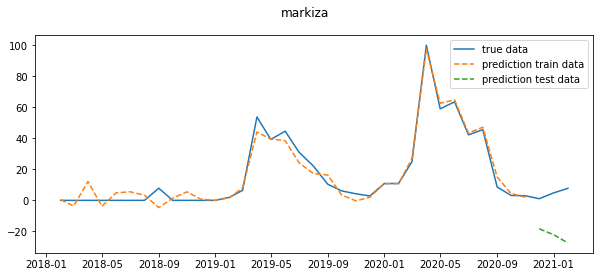

In [92]:
fig, ax = plt.subplots(1,1, figsize = (10,4))

fig.suptitle('markiza')
cols = f"{prod}_trends_whole_sells_temp_covid"
# cols = 'trends_temp_covid'
train = MODELS[cols][1]
train_forecast = MODELS[cols][0].predict(train)
test = MODELS[cols][2]
forecast = MODELS[cols][3]

plt.plot(train["y"].append(test["y"]), label="true data")
plt.plot(train_forecast["ds"], train_forecast["yhat"], label="prediction train data", linestyle="--")
plt.plot(forecast["ds"], forecast["yhat"], label = "prediction test data", linestyle="--")
plt.legend()
plt.show()

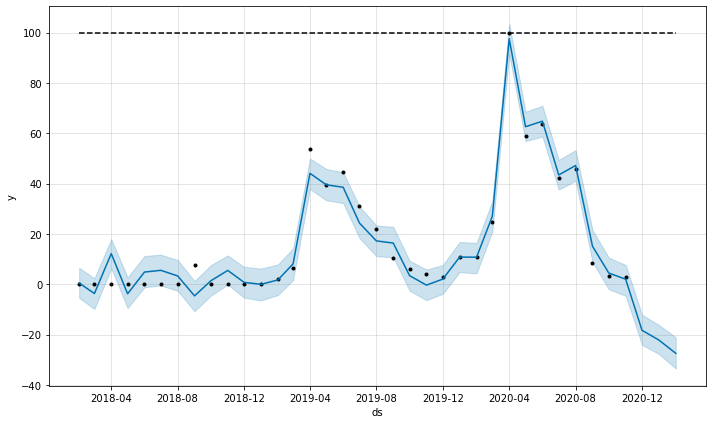

In [93]:
MODELS[cols][0].plot(train_forecast.append(forecast))
plt.show()

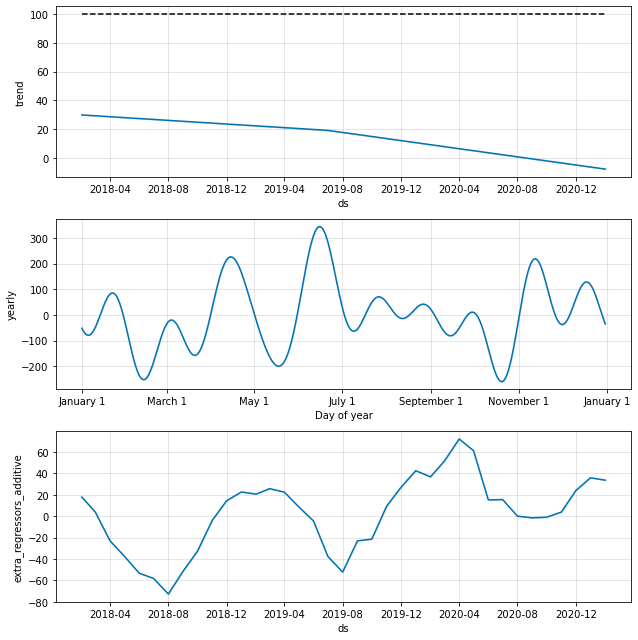

In [94]:
MODELS[cols][0].plot_components(train_forecast.append(forecast))
plt.show()

In [51]:
markiza

[(0.3263018143453981, 'whole_sells'),
 (0.25703379215683847, 'covid'),
 (0.21576608390711094, 'trends'),
 (0.2008983095906525, 'temp')]

#### Koniec analyzy markizy

In [44]:
fontdobasenu = feature_importance_merge_products(['fontanna do basenu'])
fontdobasenu

[(0.5536362373765936, 'temp'),
 (0.16790293399962572, 'covid'),
 (0.14342398419383853, 'trends'),
 (0.13503684442994218, 'whole_sells')]

In [48]:
zegarscienny = feature_importance_merge_products(['zegar ścienny'])
zegarscienny

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['trends', 'whole_sells', 'temp', 'covid']
MSE:   1014.49758184044
MAE:   29.833019971099116
MAPE:  0.40018418775972026
EVS:   -2.2227016461441758


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['whole_sells', 'temp', 'covid']
MSE:   1659.4497416449615
MAE:   35.410803004455126
MAPE:  0.4585458679623362
EVS:   -3.0130730899750606


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['trends', 'temp', 'covid']
MSE:   2016.9119052709202
MAE:   34.414651704738155
MAPE:  0.42393261774284174
EVS:   -1.6448022301890606


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


['trends', 'whole_sells', 'covid']
MSE:   1329.375092962816
MAE:   35.58127795900307
MAPE:  0.4945522333655393
EVS:   -2.348755383387094
['trends', 'whole_sells', 'temp']
MSE:   829.5908615916427
MAE:   28.37307121788616
MAPE:  0.38810994362708834
EVS:   -1.4596700180014994


In [65]:
stojaknabuty = feature_importance_merge_products(['stojak na buty'])
stojaknabuty

Request:  stojak na buty - status fail: Google 429


KeyboardInterrupt: 

In [58]:
merge_feature_importances([dc, zegarscienny])

[(0.5638187279000676, 'temp'),
 (0.24920679624639164, 'trends'),
 (0.13974428881232562, 'whole_sells'),
 (0.04723018704121499, 'covid')]

In [ ]:
merge_feature_importances([dc, zegarscienny, stojaknabuty])